<a href="https://colab.research.google.com/github/Monsurat-Onabajo/DeepLearning_projects/blob/main/Pytorch_Paper_Replicating.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Replicating the vision transformer (VIT) paper with pytorch

## Get Setup

Importing code we've previously written

In [ ]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

[INFO] torch/torchvision versions not as required, installing nightly versions.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://download.pytorch.org/whl/cu113
torch version: 2.0.1+cu118
torchvision version: 0.15.2+cu118


In [ ]:
device='cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

## Getting Data

In [ ]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data/pizza_steak_sushi directory exists, skipping download.


PosixPath('data/pizza_steak_sushi')

In [ ]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

## Create datasets and dataloaders: Transforming according to the paper we are replicating

In [ ]:
IMG_SIZE =224
# create transform pipeline
from torchvision import transforms
manual_transform= transforms.Compose([transforms.Resize((IMG_SIZE, IMG_SIZE)),
                                      transforms.ToTensor()])
manual_transform

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
)

In [ ]:
# the paper uses batchsize of 4096 but it may be too big for our hardware so we will be using 32
batch_size=32
train_dataloader, test_dataloader, class_names= data_setup.create_dataloaders(train_dir= train_dir, test_dir=test_dir,
                                                                              transform= manual_transform ,batch_size=batch_size)

In [ ]:
len(train_dataloader), len(test_dataloader), len(class_names)

(8, 3, 3)

## Visualize a single image

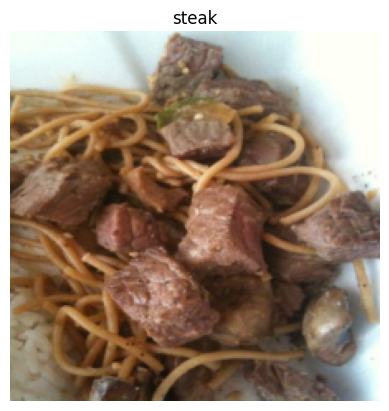

In [ ]:
img, title= next(iter(train_dataloader))
image= img[1]
title= title[1]
import matplotlib.pyplot as plt
plt.imshow(image.permute(1,2,0))
plt.title(class_names[title])
plt.axis(False);

## EQUATION 1: Split data into patches and creating the class position and patch embedding

* Layers= input -> function -> output

## According to the ViT Paper,
* the input image is H x W x C
* The output image is N x (P**2 . C)
* N= HW/P**2 where P is the resolution of each image patch( Patch Size)

In [ ]:
# Create example values
height=224
width=224
color=3
patch_size=16

# Claculate number of patches
no_of_patches= int((height*width)/patch_size**2)
no_of_patches

196

In [ ]:
# input shape
embedding_layer_input_shape= (height,width,color)

#output_shape
embedding_layer_output_shape= (no_of_patches, patch_size**2 * color)

print(f'Input shape (simgle 2D image): {embedding_layer_input_shape}')
print(f'Output shape (single 1D sequence of patches): {embedding_layer_output_shape} -> number of patches, embedding size/ dimensions')

Input shape (simgle 2D image): (224, 224, 3)
Output shape (single 1D sequence of patches): (196, 768) -> number of patches, embedding size/ dimensions


# Turning a single image into patches

Text(0.5, 1.0, 'steak')

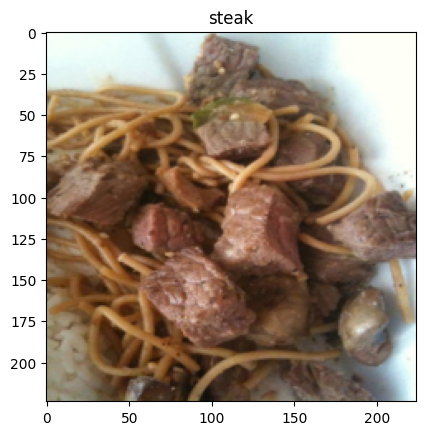

In [ ]:
plt.imshow(image.permute(1,2,0))
plt.title(class_names[title])
#plt.axis(False);

In [ ]:
image.shape

torch.Size([3, 224, 224])

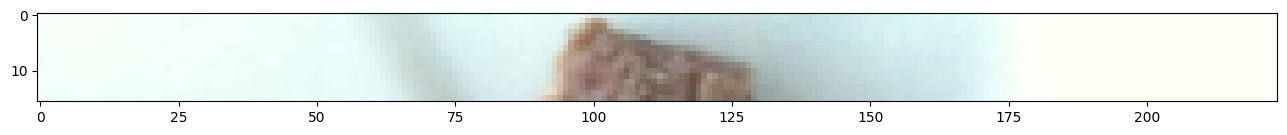

In [ ]:
# get the top row of the image
image_permuted= image.permute(1,2,0)

# index to plt the top row of the pixels
patch_size=16
plt.figure(figsize= (patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :])

In [ ]:
image_permuted[:patch_size, :, :].shape

torch.Size([16, 224, 3])

No of patches per row: 14.0 
Patch size: 16 pixels x 16 pixels


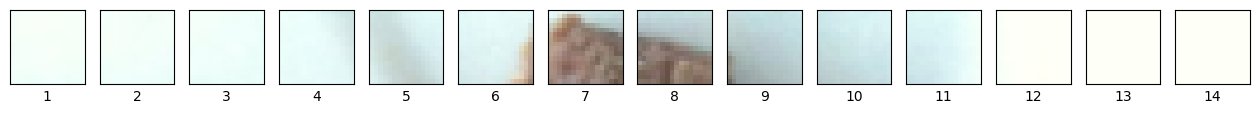

In [ ]:
# Setup code to plot top row  as patches
img_size=224
patch_size=16
num_patches= img_size/patch_size
assert img_size % patch_size==0, ' Image size must be divisible by patchsize to get even patches'
print (f'No of patches per row: {num_patches} \nPatch size: {patch_size} pixels x {patch_size} pixels')

# Create a series of subplots
fig, ax= plt.subplots(nrows=1,
                      ncols= img_size // patch_size, # one col per patch
                      sharex= True, sharey= True, figsize= (patch_size, patch_size))

# Iterate through no of patches in the top row
for i, patch in enumerate(range(0, img_size, patch_size)): # start, stop, step
  ax[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :])
  ax[i].set_xlabel(i+1)
  ax[i].set_xticks([])
  ax[i].set_yticks([])



No of patches per row: 14.0
No of patches per column: 14.0
Total Patches 196.0  
Patch size: 16 pixels x 16 pixels


Text(0.5, 0.98, 'steak')

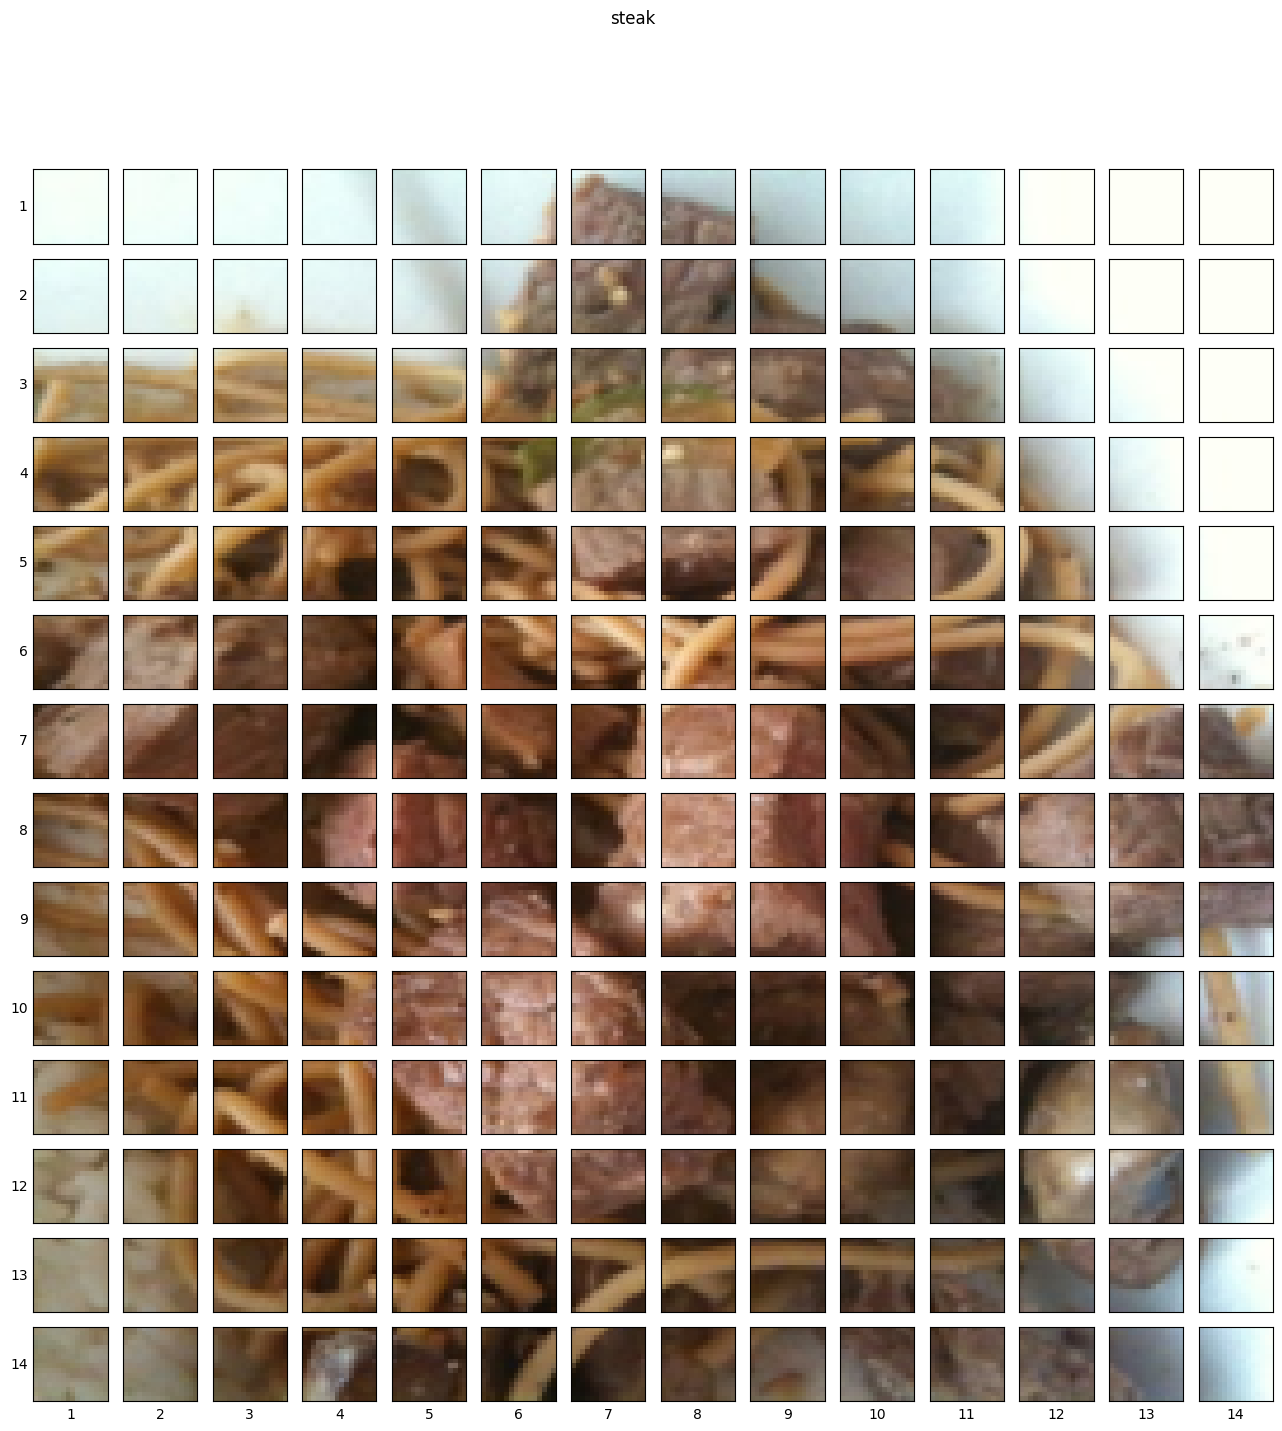

In [ ]:
# Setup code to plot whole image as patches
img_size=224
patch_size=16
num_patches= img_size/patch_size
assert img_size % patch_size==0, ' Image size must be divisible by patchsize to get even patches'
print (f'No of patches per row: {num_patches}\nNo of patches per column: {num_patches}\nTotal Patches {num_patches*num_patches}  \nPatch size: {patch_size} pixels x {patch_size} pixels')

# Create a series of subplots
fig, ax= plt.subplots(nrows=img_size // patch_size,
                      ncols= img_size // patch_size,
                      sharex= True, sharey= True, figsize= (patch_size, patch_size))

# loop through height and width of the image
for i, patch_height in enumerate(range(0, img_size, patch_size)): # Iterate through height
  for j, patch_width in enumerate(range(0, img_size, patch_size)): # iterate through width
    ax[i,j].imshow(image_permuted[patch_height:patch_height+patch_size,
                                  patch_width:patch_width+patch_size,
                                  :])
    # setup label info
    ax[i,j].set_ylabel(i+1, rotation='horizontal', horizontalalignment= 'right', verticalalignment= 'center')
    ax[i,j].set_xlabel(j+1)
    ax[i,j].set_xticks([])
    ax[i,j].set_yticks([])
    ax[i,j].label_outer()

# setup a title
fig.suptitle(f'{class_names[title]}')

# Creating image patches and turning them into patch embedings in a single step using `nn.Conv2d()` libary and setting the kernel size and stride values to patch size

In [ ]:
# Create conv2d layer
from torch import nn
# set patch size
patch_size=16

# create a conv2d layer with hyperparameters from the vit paper
conv2d= nn.Conv2d(in_channels=3, # for color channels
                 out_channels= 768, # D size from table 1 in the vit paper
                 kernel_size= patch_size,
                 stride= patch_size,
                 padding=0
                 )
conv2d

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

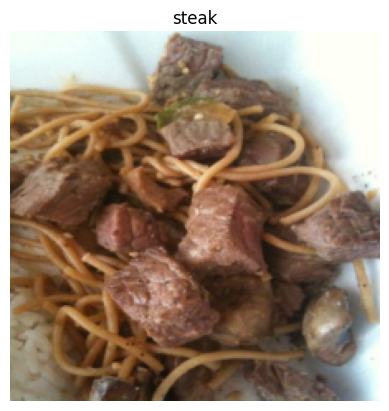

In [ ]:
# view single image
plt.imshow(image.permute(1,2,0))
plt.title(class_names[title])
plt.axis(False);

In [ ]:
# pass the image through the conv2d layer
image_conv2d= conv2d(image.unsqueeze(0)) # add batch dim -> batch_size, color_channel, height, width
image_conv2d.shape

torch.Size([1, 768, 14, 14])

Showing random convolutional featuremaps from indexes: [301, 179, 405, 32, 722]


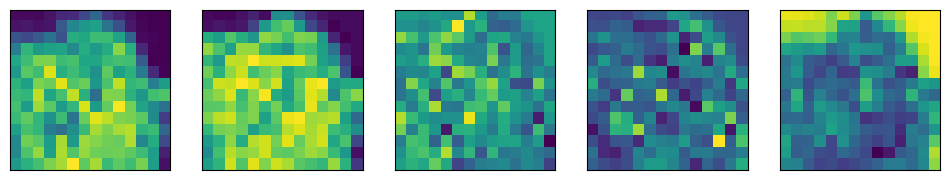

In [ ]:
# view some of our feature map by plotting random convolutional feature maps(embedding)
import random
random_indexes= random.sample(range(0,758), k=5)
print (f'Showing random convolutional featuremaps from indexes: {random_indexes}')

# create plot
fig, ax= plt.subplots(nrows=1, ncols=5, figsize=(12,12))

# plotrandom image feature map
for i, idx in enumerate(random_indexes):
  image_conv_fm= image_conv2d[:, idx, :, :] # index on the output tensor
  ax[i].imshow(image_conv_fm.squeeze().detach().numpy()) # remove batchsize dim and gradient tracking
  ax[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [ ]:
# get a single feature map in tensor foem
single= image_conv2d[:, 0, :, :]
single

tensor([[[-0.5205, -0.5150, -0.5068, -0.4846, -0.4335, -0.4032, -0.1534,
          -0.1776, -0.3235, -0.4018, -0.4691, -0.5535, -0.5561, -0.5561],
         [-0.4743, -0.4765, -0.4721, -0.4743, -0.4078, -0.3518, -0.2731,
          -0.2651, -0.1873, -0.3383, -0.4304, -0.5353, -0.5565, -0.5561],
         [-0.2487, -0.2652, -0.3229, -0.3400, -0.3290, -0.2804, -0.2822,
          -0.3294, -0.2810, -0.2442, -0.2653, -0.4362, -0.5435, -0.5565],
         [-0.3195, -0.4466, -0.3959, -0.2908, -0.3355, -0.3587, -0.3604,
          -0.3378, -0.2249, -0.1906, -0.3579, -0.3488, -0.5080, -0.5561],
         [-0.3881, -0.2763, -0.2178, -0.1936, -0.2558, -0.3638, -0.3213,
          -0.2029, -0.3415, -0.2932, -0.3041, -0.3340, -0.4373, -0.5514],
         [-0.3099, -0.3878, -0.2497, -0.1525, -0.2406, -0.2510, -0.2924,
          -0.3830, -0.2258, -0.2648, -0.1494, -0.3276, -0.4553, -0.4810],
         [-0.3326, -0.2285, -0.2076, -0.2169, -0.1990, -0.1931, -0.3370,
          -0.4530, -0.3020, -0.1602, -0.2488,

## Flattening the patch embedding with nn.flatten

In [ ]:
flatten= nn.Flatten(start_dim= 2)
flatten_image= flatten(image_conv2d)
flatten_image.shape

torch.Size([1, 768, 196])

Original image shape: torch.Size([3, 224, 224])
 Image feature map (patches) shape: torch.Size([1, 768, 14, 14])
Flattened image feature map shape: torch.Size([1, 768, 196])


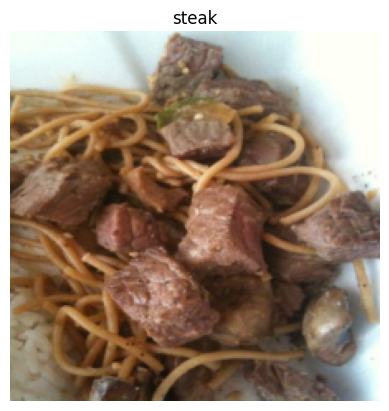

In [ ]:
#put everything together
plt.imshow(image.permute(1,2,0))
plt.title(class_names[title])
plt.axis(False)
print(f'Original image shape: {image.shape}')

# Turn image into feature map
image_out_of_conv= conv2d(image.unsqueeze(0)) # add batch dim
print(f' Image feature map (patches) shape: {image_out_of_conv.shape}')

# Flatten the feature maps
image_out_of_conv_flatten= flatten(image_out_of_conv)
print(f'Flattened image feature map shape: {image_out_of_conv_flatten.shape}')

# Rearrange output of flattened layer

In [ ]:
print(f'{image_out_of_conv_flatten.permute(0,2,1).shape} -> [batch_size, num_patches, embedding_size]')

torch.Size([1, 196, 768]) -> [batch_size, num_patches, embedding_size]


Text(0.5, 1.0, 'Flattened feature map shape: (1, 196)')

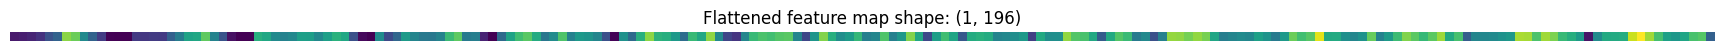

In [ ]:
a= image_out_of_conv_flatten.permute(0,2,1).detach().numpy()
plt.figure(figsize=(22,22))
plt.imshow(a[:, :, 0])
plt.axis(False)
plt.title(f'Flattened feature map shape: {a[:,:,0].shape}')

## Turning the vit patch embedding layer into pytorch code

In [ ]:
class PatchEmbedding(nn.Module):
  def __init__(self, in_channels:int=3, embedding_dim:int=768, patch_size:int=16):
    super().__init__()
    self.patch_size=patch_size
    self.first_layer= nn.Conv2d(in_channels= in_channels,
                                out_channels= embedding_dim,
                                stride= patch_size,
                                padding=0,
                                kernel_size=patch_size)
    self.second_layer= nn.Flatten(start_dim=2)

  def forward(self, x):
    # create assertion to check that inputs are the correct shape
    image_resolution = x.shape[-1]
    assert image_resolution % patch_size==0, f'Input shape must be divisible by patch size, image shape: {image_resolution}, patch size: {self.patch_size}'
    x= self.second_layer(self.first_layer(x))
    return x.permute(0,2,1)


In [ ]:
set_seeds()
pachify_model= PatchEmbedding()

# Pass a single image through patch embedding layer
print(f'Input image size: {image.unsqueeze(0).shape}')
pachify_model_image= pachify_model(image.unsqueeze(0))
print(f'output image size: {pachify_model_image.shape}')

Input image size: torch.Size([1, 3, 224, 224])
output image size: torch.Size([1, 196, 768])


## Creating the class token embedding
Want to prepend a learnable class token to the start of the patch embedding

In [ ]:
# Get the batch size and embedding dim
batch_size= pachify_model_image.shape[0]
embedded_dim= pachify_model_image.shape[-1]
batch_size, embedded_dim

(1, 768)

In [ ]:
# create class token embedding that shares the same size as the embedding dim (D)
class_token= nn.Parameter(torch.ones(batch_size, 1, embedded_dim,), requires_grad= True)
class_token.shape

torch.Size([1, 1, 768])

In [ ]:
# Add the class token embedding to the front of the patch embedding
patch_embedded_image_with_class_emb= torch.cat((class_token, pachify_model_image),
                                               dim=1)
print (patch_embedded_image_with_class_emb)
print (f'Sequence of patch embeddings with class token prepended shape: {patch_embedded_image_with_class_emb.shape}-> [batch_size, number_of_patches, embedding_dimension]')

tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-1.0057,  0.2939, -0.2947,  ...,  0.7853, -0.4535,  0.3511],
         [-0.9996,  0.3003, -0.2999,  ...,  0.7759, -0.4501,  0.3520],
         ...,
         [-0.3905,  0.0704, -0.1280,  ...,  0.2294, -0.1821,  0.1832],
         [-0.5035,  0.2040, -0.1108,  ...,  0.3166, -0.2033,  0.1560],
         [-0.9849,  0.3449, -0.2244,  ...,  0.7686, -0.4241,  0.1315]]],
       grad_fn=<CatBackward0>)
Sequence of patch embeddings with class token prepended shape: torch.Size([1, 197, 768])-> [batch_size, number_of_patches, embedding_dimension]


## Creating Position Embeddings

In [ ]:
patch_embedded_image_with_class_emb, patch_embedded_image_with_class_emb.shape

(tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [-1.0057,  0.2939, -0.2947,  ...,  0.7853, -0.4535,  0.3511],
          [-0.9996,  0.3003, -0.2999,  ...,  0.7759, -0.4501,  0.3520],
          ...,
          [-0.3905,  0.0704, -0.1280,  ...,  0.2294, -0.1821,  0.1832],
          [-0.5035,  0.2040, -0.1108,  ...,  0.3166, -0.2033,  0.1560],
          [-0.9849,  0.3449, -0.2244,  ...,  0.7686, -0.4241,  0.1315]]],
        grad_fn=<CatBackward0>),
 torch.Size([1, 197, 768]))

In [ ]:
# calc no of patches
no_patches= int((height*width)/ patch_size**2)

# get the embedding dim
embed_dim= patch_embedded_image_with_class_emb.shape[-1]

# create position embedding
pos_embed= nn.Parameter(torch.ones(1,
                                  no_patches+1,
                                  embed_dim),
                        requires_grad= True)
pos_embed.shape

torch.Size([1, 197, 768])

In [ ]:
# Add the position embedding to the patch embeddings
patch_pos_embed=  patch_embedded_image_with_class_emb + pos_embed
patch_pos_embed

tensor([[[ 2.0000e+00,  2.0000e+00,  2.0000e+00,  ...,  2.0000e+00,
           2.0000e+00,  2.0000e+00],
         [-5.6527e-03,  1.2939e+00,  7.0532e-01,  ...,  1.7853e+00,
           5.4651e-01,  1.3511e+00],
         [ 3.5733e-04,  1.3003e+00,  7.0015e-01,  ...,  1.7759e+00,
           5.4985e-01,  1.3520e+00],
         ...,
         [ 6.0948e-01,  1.0704e+00,  8.7202e-01,  ...,  1.2294e+00,
           8.1788e-01,  1.1832e+00],
         [ 4.9652e-01,  1.2040e+00,  8.8921e-01,  ...,  1.3166e+00,
           7.9667e-01,  1.1560e+00],
         [ 1.5108e-02,  1.3449e+00,  7.7557e-01,  ...,  1.7686e+00,
           5.7590e-01,  1.1315e+00]]], grad_fn=<AddBackward0>)

In [ ]:
patch_pos_embed.shape

torch.Size([1, 197, 768])

## Putting it all together: EQN 1

In [ ]:
# set the seeds
set_seeds()

# set patch size
patch_size=16

# print shapes of original image and get image dim
print(f'Image tensor shape: {image.shape}')
height, width= image.shape[1], image.shape[2]

# get image tensor and add a batch dim
x= image.unsqueeze(0)
print (f'inout image shape: {x.shape}')

# create patch embedding layer
patch_layer= PatchEmbedding()

# Pass input image thru patch embedding layer
patch_embed= patch_layer(x)
print(f'Patch embedding shape: {patch_embed}')

# create class token embedding
batch_size= patch_embed.shape[0]
embed_dim= patch_embed.shape[-1]
class_token= nn.Parameter(torch.ones(batch_size, 1, embed_dim), requires_grad= True)
print (f'class token embedding shape: {class_token.shape}')

# prepend the class token embeding to patch embed
patch_embed_class_token= torch.cat((class_token, patch_embed), dim=1)
print(f'patch embedding with class token shape: {patch_embed_class_token.shape}')

# create position embedding
no_patches= int((height*width)/ patch_size**2)
pos_emb= nn.Parameter(torch.ones(1,no_patches +1, embed_dim), requires_grad= True)

# add the position embedding to patch embedding with class token
patch_and_position_embed= patch_embed_class_token+ pos_emb
print(f'patch and position embedding shape: {patch_and_position_embed.shape}')

Image tensor shape: torch.Size([3, 224, 224])
inout image shape: torch.Size([1, 3, 224, 224])
Patch embedding shape: tensor([[[-1.0057,  0.2939, -0.2947,  ...,  0.7853, -0.4535,  0.3511],
         [-0.9996,  0.3003, -0.2999,  ...,  0.7759, -0.4501,  0.3520],
         [-0.9972,  0.2912, -0.2945,  ...,  0.7738, -0.4459,  0.3479],
         ...,
         [-0.3905,  0.0704, -0.1280,  ...,  0.2294, -0.1821,  0.1832],
         [-0.5035,  0.2040, -0.1108,  ...,  0.3166, -0.2033,  0.1560],
         [-0.9849,  0.3449, -0.2244,  ...,  0.7686, -0.4241,  0.1315]]],
       grad_fn=<PermuteBackward0>)
class token embedding shape: torch.Size([1, 1, 768])
patch embedding with class token shape: torch.Size([1, 197, 768])
patch and position embedding shape: torch.Size([1, 197, 768])


## Equation 2: Multihead Self Attention (MSA) Layer

In [ ]:
class MultiHeadSelfAttentionBlock(nn.Module):
  '''Creates a multihead self attention block (msq)'''
  def __init__(self, embedding_dim:int=768, num_heads:int= 12, attn_dropout:int=0): # from table 1 vit base
    super().__init__()
    # Create the norm layer
    self.layer_norm= nn.LayerNorm(normalized_shape=embedded_dim)
    # Create the MSA layer
    self.msa= nn.MultiheadAttention(embed_dim=embedding_dim,
                                    num_heads= num_heads, dropout= attn_dropout, batch_first= True)
  def forward(self, x):
    x= self.layer_norm(x)
    attn_output, _ =self.msa(query=x, key=x, value= x, need_weights= False)
    return attn_output

In [ ]:
msa_block= MultiHeadSelfAttentionBlock()
# PASS THE PATCH IMAGE THROUGH IT
patch_image_msa_block= msa_block(patch_and_position_embed)
patch_image_msa_block, patch_image_msa_block.shape

(tensor([[[-0.2355, -0.2328,  0.0564,  ..., -0.4369,  0.9284, -0.4762],
          [-0.2337, -0.2245,  0.0581,  ..., -0.4314,  0.9341, -0.4889],
          [-0.2337, -0.2244,  0.0581,  ..., -0.4314,  0.9341, -0.4889],
          ...,
          [-0.2342, -0.2244,  0.0583,  ..., -0.4297,  0.9341, -0.4885],
          [-0.2338, -0.2272,  0.0586,  ..., -0.4300,  0.9335, -0.4878],
          [-0.2340, -0.2259,  0.0585,  ..., -0.4313,  0.9336, -0.4876]]],
        grad_fn=<TransposeBackward0>),
 torch.Size([1, 197, 768]))

## Equation 3: MLP Layer( Multi Layer Perceptron)

In [ ]:
class MultiLayerPerceptronBlock(nn.Module):
  def __init__(self, embedding_dim: int=768, mlp_size: int=3072,dropout: int=0.1 ):
    super().__init__()
    # create the norm layer (LN)
    self.layer_norm= nn.LayerNorm(normalized_shape=embedding_dim)

    # Create Multi layer perceptron layer
    self.mlp= nn.Sequential(
        nn.Linear(in_features=embedding_dim, out_features= mlp_size),
        nn.GELU(),
        nn.Dropout(p=dropout),
        nn.Linear(in_features= mlp_size, out_features= embedding_dim),
        nn.Dropout(p=dropout)
        )
  def forward(self, x):
    x= self.layer_norm(x)
    x= self.mlp(x)
    return x


In [ ]:
# Create an instance of MLP block
mlp_block= MultiLayerPerceptronBlock()
# Pass image thru MSA block thru MLP block
patch_image_msa_mlp_block= mlp_block(patch_image_msa_block)
patch_image_msa_mlp_block, patch_image_msa_mlp_block.shape

(tensor([[[-0.0380, -0.0142,  0.1854,  ...,  0.0000, -0.1838,  0.1888],
          [-0.0994, -0.1314,  0.2872,  ..., -0.0915, -0.1576,  0.2161],
          [-0.0030, -0.0548,  0.3025,  ..., -0.0000, -0.2200,  0.2061],
          ...,
          [-0.1795, -0.0243,  0.2905,  ...,  0.1212, -0.2285,  0.2875],
          [-0.1170,  0.0343,  0.0000,  ...,  0.0571, -0.2042,  0.0828],
          [-0.0631, -0.0378,  0.2477,  ..., -0.1070, -0.1907,  0.1859]]],
        grad_fn=<MulBackward0>),
 torch.Size([1, 197, 768]))

## Creating the transformer encoder

The tranformer encoder is a combination of alternating blocks of MSA and MLP and there are residual connections between each blocks

In [ ]:
class TransformerEncoderBlock(nn.Module):
  def __init__(self,
               embedding_dim:int=768,
               num_heads:int= 12,
               attn_dropout:int=0,
               mlp_size: int=3072,
               dropout: int=0.1 ): # from table 1 vit base
    super().__init__()
    # Create MSA Block
    self.msa= MultiHeadSelfAttentionBlock(embedding_dim= embedding_dim, num_heads= num_heads, attn_dropout= attn_dropout)
    # MLP Block
    self.mlp= MultiLayerPerceptronBlock(embedding_dim= embedding_dim, mlp_size= mlp_size,dropout= dropout)
  def forward(self, x):
    x= self.msa(x) + x
    x= self.mlp(x) + x
    return (x)



In [ ]:
# Create an instance of transformer encoder block
transformer_block= TransformerEncoderBlock()

# Get a summary of the module
summary(model= transformer_block,
        input_size=(1,197,768),
        col_names= ['input_size', 'output_size','num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiHeadSelfAttentionBlock (msa)                [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (msa)                    --                   [1, 197, 768]        2,362,368            True
├─MultiLayerPerceptronBlock (mlp)                  [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

# Create a transformer encoder block with inbuilt pytorch layers

In [ ]:
# Create the same as above with torch.nn.TransformerEncoderLayer()
torch_transformer_layer= nn.TransformerEncoderLayer(d_model=768, #no of embedding dim
                                                    nhead=12, # head from table 1
                                                    dim_feedforward=3072, # MLP size from Table 1 for ViT-Base
                                                    dropout=0.1,
                                                    activation='gelu',
                                                    batch_first= True,
                                                    norm_first= True)
torch_transformer_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [ ]:
# Get a summary of the module
summary(model= torch_transformer_layer,
        input_size=(1,197,768),
        col_names= ['input_size', 'output_size','num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]        [1, 197, 768]        7,087,872            True
Total params: 7,087,872
Trainable params: 7,087,872
Non-trainable params: 0
Total mult-adds (M): 0
Input size (MB): 0.61
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.61

# Putting it all together to create VIT

In [ ]:
class ViT(nn.Module):
  def __init__(self,
               image_size:int=224,
               in_channels:int=3,
               patch_size=16,
               num_transformer_layer=12, #layers in vit base
               embedding_dim: int= 768,
               mlp_size:int=3072,
               num_head:int=12,
               attn_dropout: int=0,
               mlp_dropout:int=0.1,
               embedding_dropout:int=0.1,
               num_classes:int=1000
               ):
    super().__init__()
    # make an assetion that the image patch is compatible with the patch size
    assert image_size % patch_size==0, f'image size must be divisible by patch size: {image_size}, patch size {patch_size}'

    # Calc no of patches (height * width/patch^2)
    self.num_patches= (image_size* image_size)//patch_size**2

    # Create learnable class embedding (need to go at front of sequence of patch embedding)
    self.class_embedding= nn.Parameter(data= torch.randn(1,1,embedding_dim), requires_grad=True)

    # Create Position embedding
    self.position_embedding= nn.Parameter(torch.randn(1, self.num_patches+1, embedding_dim), requires_grad= True)

    # Create embedding dropout value
    self.embedding_dropout= nn.Dropout(p=embedding_dropout)

    # create patch embedding layer
    self.patch_embedding= PatchEmbedding(in_channels= in_channels, embedding_dim= embedding_dim, patch_size=patch_size)

    # Create transformer encoder block
    self.transformer_encoder= nn.Sequential(*[TransformerEncoderBlock(embedding_dim= embedding_dim,
                                                                      num_heads=num_head, attn_dropout= attn_dropout,
                                                                      mlp_size=mlp_size, dropout=mlp_dropout) for _ in range(num_transformer_layer)])

    # Create classifier head
    self.classifier= nn.Sequential(nn.LayerNorm(normalized_shape=embedding_dim),
                                   nn.Linear(in_features= embedding_dim, out_features= num_classes))

  def forward(self, x):
    # Get the batch size
    batch_size=x.shape[0]

    # Create the class token embedding and expand it to match the batch size
    class_token= self.class_embedding.expand(batch_size, -1, -1)

    # Create the patch embedding
    x= self.patch_embedding(x)

    # concat class token embedding and patch embedding
    x= torch.cat((class_token, x), dim=1)

    # Add position embedding to class token and patch embedding
    x= self.position_embedding + x

    # apply embedding dropout
    x= self.embedding_dropout(x)

    # Pass position and patch embedding to transformer encoder
    x= self.transformer_encoder(x)

    # put 0th index logits through the classifier
    x = self.classifier(x[:,0])

    return x



In [ ]:
vit= ViT()
vit

ViT(
  (embedding_dropout): Dropout(p=0.1, inplace=False)
  (patch_embedding): PatchEmbedding(
    (first_layer): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (second_layer): Flatten(start_dim=2, end_dim=-1)
  )
  (transformer_encoder): Sequential(
    (0): TransformerEncoderBlock(
      (msa): MultiHeadSelfAttentionBlock(
        (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (msa): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
      )
      (mlp): MultiLayerPerceptronBlock(
        (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.1, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.1, inplace=False)
        )
      )
    

In [ ]:
set_seeds()
# create a random image tensor
random= torch.randn(1,3,224,224)
# pass it into the model
vit= ViT(num_classes=3)
vit(random)

tensor([[-0.2377,  0.7360,  1.2137]], grad_fn=<AddmmBackward0>)

In [ ]:
## Getting a visual summary of our model
# Get a summary of the module
summary(model= ViT(num_classes=1000),
        input_size=(1,3,224,224),
        col_names= ['input_size', 'output_size','num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                          [1, 3, 224, 224]     [1, 1000]            152,064              True
├─PatchEmbedding (patch_embedding)                 [1, 3, 224, 224]     [1, 196, 768]        --                   True
│    └─Conv2d (first_layer)                        [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
│    └─Flatten (second_layer)                      [1, 768, 14, 14]     [1, 768, 196]        --                   --
├─Dropout (embedding_dropout)                      [1, 197, 768]        [1, 197, 768]        --                   --
├─Sequential (transformer_encoder)                 [1, 197, 768]        [1, 197, 768]        --                   True
│    └─TransformerEncoderBlock (0)                 [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─MultiHeadSelfAttentionBlock (msa)  

# Creating loss function and optimizer

In [ ]:
# creating optimiser and loss function
vit_model= ViT(num_classes=3).to(device)
optim= torch.optim.Adam(vit_model.parameters(),lr=0.001, betas= (0.9, 0.999), weight_decay=0.1)
loss_fn= nn.CrossEntropyLoss()

# Training our model with the going modular library

In [ ]:
from going_modular.going_modular import engine
result= engine.train(model= vit_model, train_dataloader= train_dataloader,
                     test_dataloader= test_dataloader, optimizer= optim, loss_fn= loss_fn, epochs=10, device= device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.4511 | train_acc: 0.4062 | test_loss: 2.3362 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.6090 | train_acc: 0.2422 | test_loss: 1.0209 | test_acc: 0.5417
Epoch: 3 | train_loss: 1.3698 | train_acc: 0.2695 | test_loss: 1.2054 | test_acc: 0.1979
Epoch: 4 | train_loss: 1.4889 | train_acc: 0.2773 | test_loss: 1.2202 | test_acc: 0.1979
Epoch: 5 | train_loss: 1.2199 | train_acc: 0.2539 | test_loss: 1.0267 | test_acc: 0.5417
Epoch: 6 | train_loss: 1.3082 | train_acc: 0.2617 | test_loss: 1.2592 | test_acc: 0.1979
Epoch: 7 | train_loss: 1.1255 | train_acc: 0.4062 | test_loss: 2.2156 | test_acc: 0.1979
Epoch: 8 | train_loss: 1.5817 | train_acc: 0.2773 | test_loss: 1.0819 | test_acc: 0.2604
Epoch: 9 | train_loss: 1.2134 | train_acc: 0.3008 | test_loss: 2.6893 | test_acc: 0.1979
Epoch: 10 | train_loss: 1.5973 | train_acc: 0.2500 | test_loss: 1.3389 | test_acc: 0.2604


## Plot loss curves for our model

In [ ]:
result

{'train_loss': [3.4510537423193455,
  1.6090143769979477,
  1.3698138892650604,
  1.4889336377382278,
  1.219913810491562,
  1.3081988543272018,
  1.1255202367901802,
  1.5816976577043533,
  1.2133948802947998,
  1.5972577333450317],
 'train_acc': [0.40625,
  0.2421875,
  0.26953125,
  0.27734375,
  0.25390625,
  0.26171875,
  0.40625,
  0.27734375,
  0.30078125,
  0.25],
 'test_loss': [2.336213211218516,
  1.020947794119517,
  1.2053670088450115,
  1.2201708157857258,
  1.0266842643419902,
  1.2592222293217976,
  2.2155791521072388,
  1.0819131135940552,
  2.689262946446737,
  1.338856816291809],
 'test_acc': [0.2604166666666667,
  0.5416666666666666,
  0.19791666666666666,
  0.19791666666666666,
  0.5416666666666666,
  0.19791666666666666,
  0.19791666666666666,
  0.2604166666666667,
  0.19791666666666666,
  0.2604166666666667]}

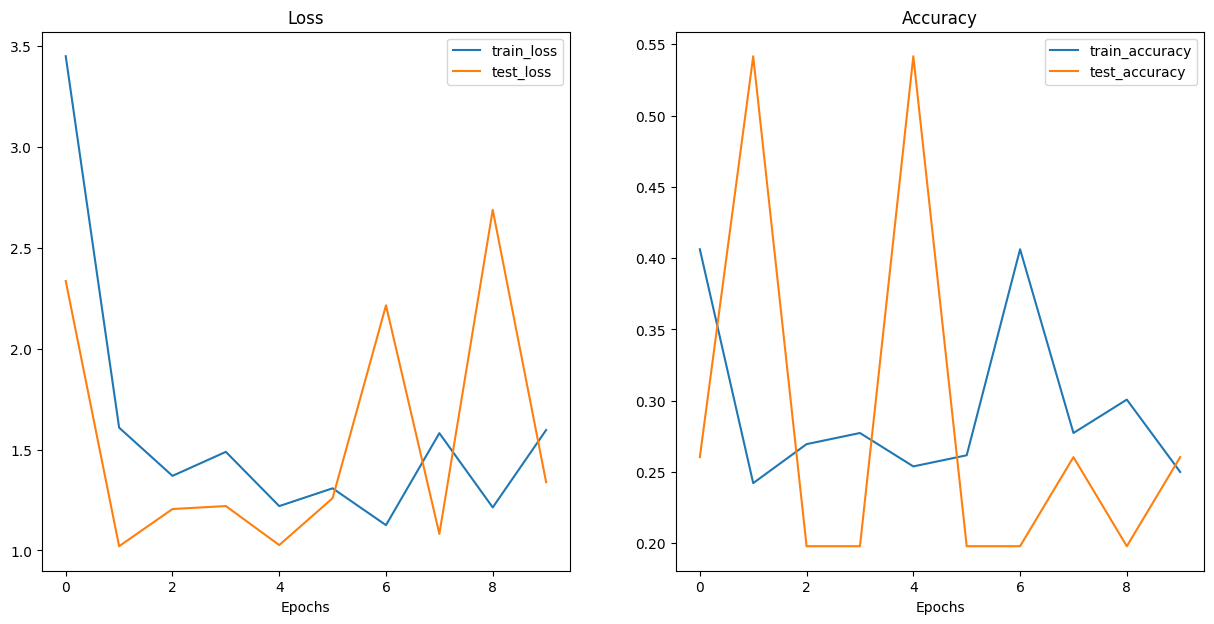

In [ ]:
from helper_functions import plot_loss_curves

plot_loss_curves(result)

# Using Transfer Learning FOR our model i.e a pretrained Vit model from torchvision.models

In [ ]:
# get pretrained weights
weights= torchvision.models.ViT_B_16_Weights.DEFAULT
# setup vit model instance
pretrained_vit= torchvision.models.vit_b_16(weights= weights).to(device)
dir(weights)

['__class__',
 '__doc__',
 '__module__',
 'get_state_dict',
 'meta',
 'name',
 'transforms',
 'url',
 'value',
 'verify']

In [ ]:
# freeze the base parameters

for param in pretrained_vit.parameters():
  param.requires_grad= False

# update the classifier head
set_seeds()
pretrained_vit.heads= nn.Linear(in_features=768, out_features=len(class_names), bias= True).to(device)

In [ ]:
## Getting a visual summary of our model
# Get a summary of the module
summary(model= pretrained_vit,
        input_size=(1,3,224,224),
        col_names= ['input_size', 'output_size','num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

# Preparing our data for the transfer learning model

In [ ]:
transforms= weights.transforms()
transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [ ]:
# Setup data loader using this transformation
train_dataloader_new, test_dataloader_new, class_names= data_setup.create_dataloaders(train_dir= train_dir,
                                                                                      test_dir= test_dir,
                                                                                      batch_size=32, transform= transforms)

In [ ]:
# Creating loss and optimization
optim= torch.optim.Adam(pretrained_vit.parameters(), lr=0.001)
loss_fn= nn.CrossEntropyLoss()

In [ ]:
## Train feature extractor vit model
set_seeds()
result= engine.train(model=pretrained_vit, train_dataloader= train_dataloader_new,
                     test_dataloader= test_dataloader_new, loss_fn= loss_fn, optimizer= optim,
                     epochs=10, device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7665 | train_acc: 0.7227 | test_loss: 0.5432 | test_acc: 0.8665
Epoch: 2 | train_loss: 0.3428 | train_acc: 0.9453 | test_loss: 0.3263 | test_acc: 0.8977
Epoch: 3 | train_loss: 0.2064 | train_acc: 0.9531 | test_loss: 0.2707 | test_acc: 0.9081
Epoch: 4 | train_loss: 0.1556 | train_acc: 0.9570 | test_loss: 0.2422 | test_acc: 0.9081
Epoch: 5 | train_loss: 0.1246 | train_acc: 0.9727 | test_loss: 0.2279 | test_acc: 0.8977
Epoch: 6 | train_loss: 0.1216 | train_acc: 0.9766 | test_loss: 0.2129 | test_acc: 0.9280
Epoch: 7 | train_loss: 0.0938 | train_acc: 0.9766 | test_loss: 0.2352 | test_acc: 0.8883
Epoch: 8 | train_loss: 0.0797 | train_acc: 0.9844 | test_loss: 0.2281 | test_acc: 0.8778
Epoch: 9 | train_loss: 0.1098 | train_acc: 0.9883 | test_loss: 0.2074 | test_acc: 0.9384
Epoch: 10 | train_loss: 0.0650 | train_acc: 0.9883 | test_loss: 0.1804 | test_acc: 0.9176


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.0617 | train_acc: 0.9922 | test_loss: 0.1850 | test_acc: 0.9176
Epoch: 2 | train_loss: 0.0518 | train_acc: 0.9961 | test_loss: 0.1947 | test_acc: 0.9176
Epoch: 3 | train_loss: 0.0451 | train_acc: 0.9961 | test_loss: 0.2106 | test_acc: 0.9280
Epoch: 4 | train_loss: 0.0407 | train_acc: 0.9961 | test_loss: 0.2175 | test_acc: 0.9384
Epoch: 5 | train_loss: 0.0372 | train_acc: 0.9961 | test_loss: 0.2144 | test_acc: 0.9384
Epoch: 6 | train_loss: 0.0358 | train_acc: 1.0000 | test_loss: 0.2063 | test_acc: 0.9384
Epoch: 7 | train_loss: 0.0325 | train_acc: 1.0000 | test_loss: 0.2048 | test_acc: 0.9384
Epoch: 8 | train_loss: 0.0294 | train_acc: 1.0000 | test_loss: 0.2028 | test_acc: 0.9384
Epoch: 9 | train_loss: 0.0303 | train_acc: 1.0000 | test_loss: 0.2012 | test_acc: 0.9384
Epoch: 10 | train_loss: 0.0256 | train_acc: 1.0000 | test_loss: 0.1956 | test_acc: 0.9176


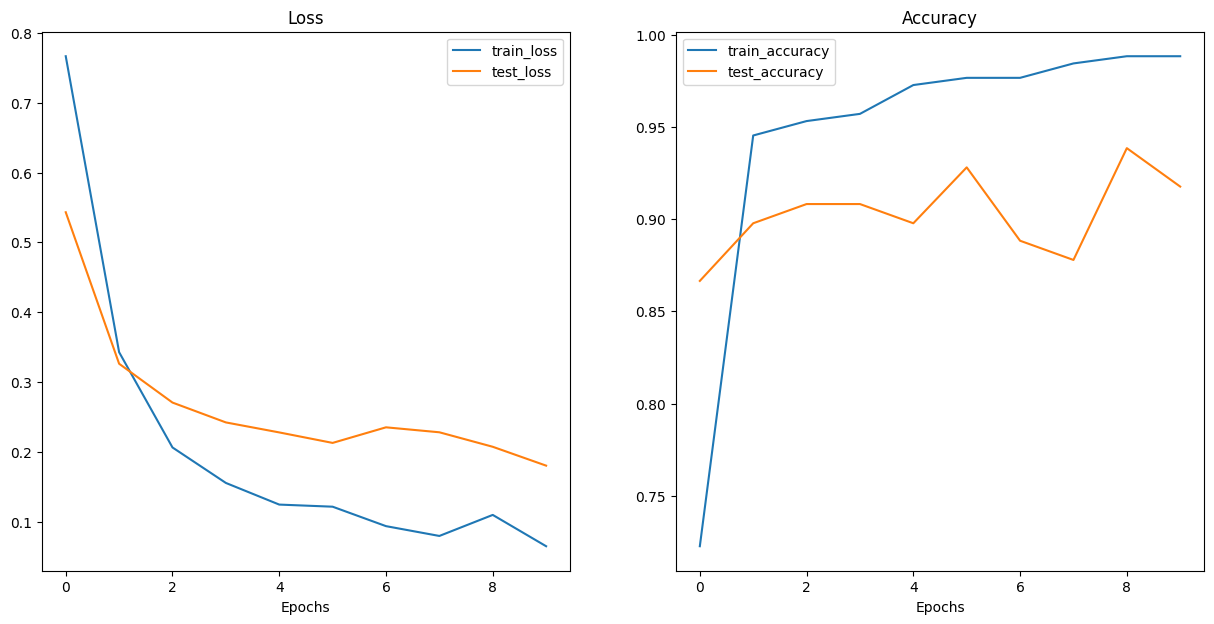

In [ ]:
# Plot the loss curve of the trained vit feature extraction model
plot_loss_curves(result)

# Save our best performing big model and checking the file size

In [ ]:
# saving a model
from  going_modular.going_modular import utils
utils.save_model(model= pretrained_vit, target_dir='models', model_name= '08_vit_model.pth')

[INFO] Saving model to: models/08_vit_model.pth


In [ ]:
from pathlib import Path

# get the model size in bytes and convert it to megabytes
file_size= Path('models/08_vit_model.pth').stat().st_size // (1024*1024)
print(f'File size: {file_size} megabytes (MB)')

File size: 327 megabytes (MB)


## Predicting on a custom image

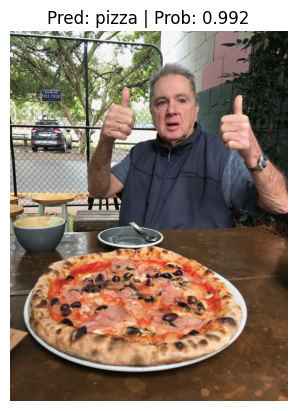

In [ ]:
import requests

# Import function to make predictions on images and plot them
from going_modular.going_modular.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = image_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)